In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

Fontconfig warning: ignoring UTF-8: not a valid region tag
Matplotlib is building the font cache; this may take a moment.


# Functions

In [2]:
# RoPE Implementation
def rope(X, channel_thetas=None, M=None):
    """
    Apply Rotary Position Embedding (RoPE) to the input embeddings.

    Args:
        X: numpy array of shape (d, seq_len) where d is the embedding dimension.
        channel_thetas: numpy array of shape (d // 2, 1) containing the rotation rate for each channel (2 dimensions).
        M: numpy array of shape (d // 2, seq_len) containing the position indices.
    Returns:
        numpy array of shape (d, seq_len) with RoPE applied.
    """
    # Assert
    assert len(X.shape) == 2, "Input array should have shape (d, seq_len)"
    assert X.shape[0] % 2 == 0, "Embedding dimension should be divisible by 2"
    
    # Constants
    d = X.shape[0]
    seq_len = X.shape[1]

    if channel_thetas is None:
        channel_thetas = np.array([[1/10000**(2*i/d)] for i in range(d//2)])

    if M is None:
        M = np.array([np.arange(seq_len),]*(d//2))

    # Calculate the rotation angles for each channel
    channel_angles = M * channel_thetas # (d//2, seq_len)

    # Expand the channel_angles
    angles = np.repeat(channel_angles, 2, axis=0) # (d, seq_len)

    # Rotation
    X_swap = np.zeros_like(X) # The second vector in the formula (34) in the RoPE paper
    X_swap[::2], X_swap[1::2] = -X[1::2], X[::2]

    X_rope = X * np.cos(angles) + X_swap * np.sin(angles)

    return X_rope
    

In [4]:
# Calculate the cosine similarity
def cosine_similarity(X1, X2):
    dot = np.dot(X1.T, X2)
    norm_X1 = np.linalg.norm(X1, axis=0, keepdims=True)
    norm_X2 = np.linalg.norm(X2, axis=0, keepdims=True)
    return dot / (norm_X1.T @ norm_X2)

In [7]:
def plot_similarity_matrix(similarity_matrix):
    plt.figure(figsize=(8, 6))
    plt.imshow(similarity_matrix, cmap='viridis', origin='lower')
    plt.colorbar(label='Similarity')
    plt.title('Cosine Similarity Matrix')
    plt.show()

In [8]:
def plot_spatial_similarity(m, w, h, similarity_matrix, line_length):
    plt.figure(figsize=(8, 6))

    map = np.zeros((h,w))
    center = m + w//2 + h//2*line_length
    for j in range(h):
        for i in range(w):
            realpos = m + j*line_length + i
            val = similarity_matrix[center,realpos]
            map[h-j-1,i] = val
            plt.text(i, h-j-1, f'{val:.2f}', ha='center', va='center', color="black")

    # Set the range from 0 to 1
    plt.imshow(map, cmap='viridis', origin='lower', vmax=1, vmin=0)
    # Set x ticks and y ticks
    plt.xticks(np.arange(0, w, 1), np.arange(0, w, 1)-w//2)
    plt.yticks(np.arange(0, h, 1), np.arange(h, 0, -1)-h//2-1)
    plt.colorbar(label='Similarity')
    plt.show()

# Experiments

In [6]:
DIMENSION = 5120
SEQ_LEN = 512
LINE_LENGTH = 32
X = np.ones((DIMENSION, SEQ_LEN))

## OriginalRoPE

In [19]:
M_rope = np.array([np.arange(SEQ_LEN),]*(DIMENSION//2))
theta_rope = np.array([[1/10000**(2*i/DIMENSION)] for i in range(DIMENSION//2)])
X_rope = rope(X, channel_thetas=theta_rope, M=M_rope)

rope_sim_matrix = cosine_similarity(X_rope, X_rope)

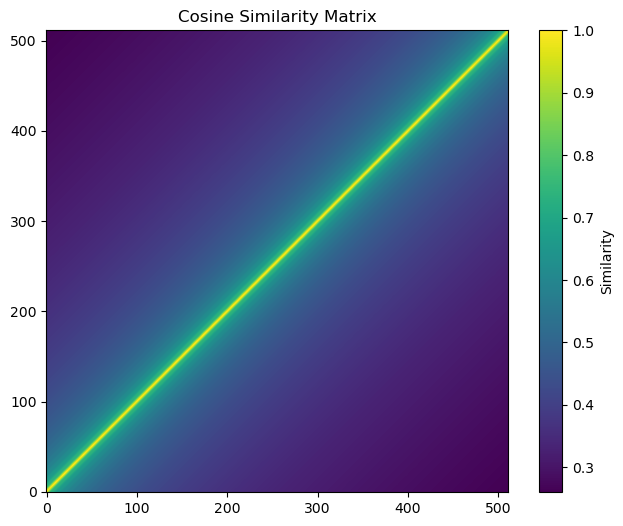

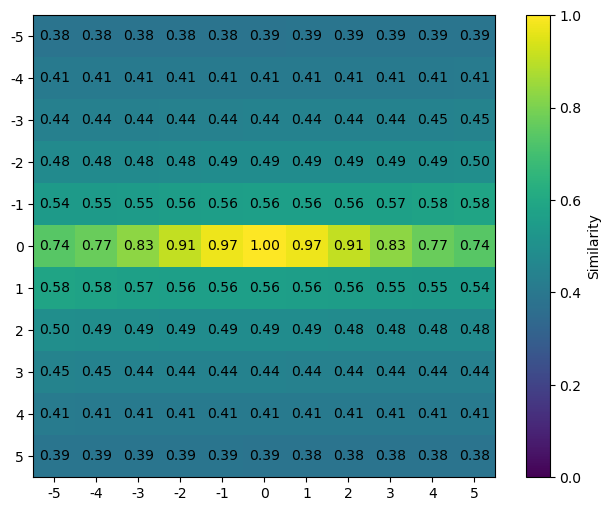

In [70]:
similarity_matrix_rope = cosine_similarity(X_rope, X_rope)
plot_similarity_matrix(similarity_matrix_rope)
plot_spatial_similarity(3, 11, 11, similarity_matrix_rope, LINE_LENGTH)


## 2D RoPE

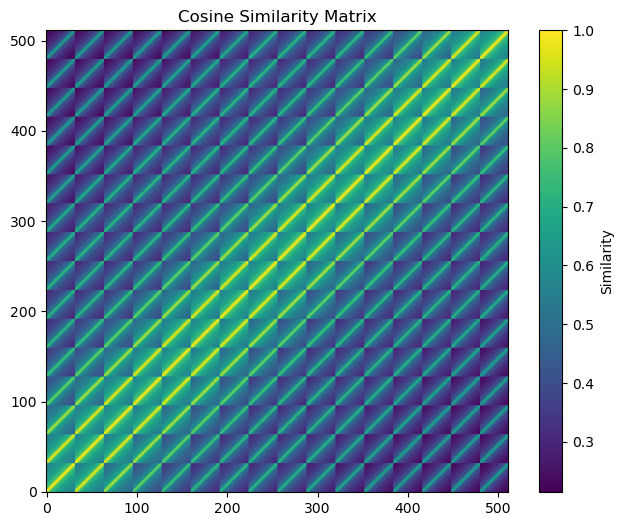

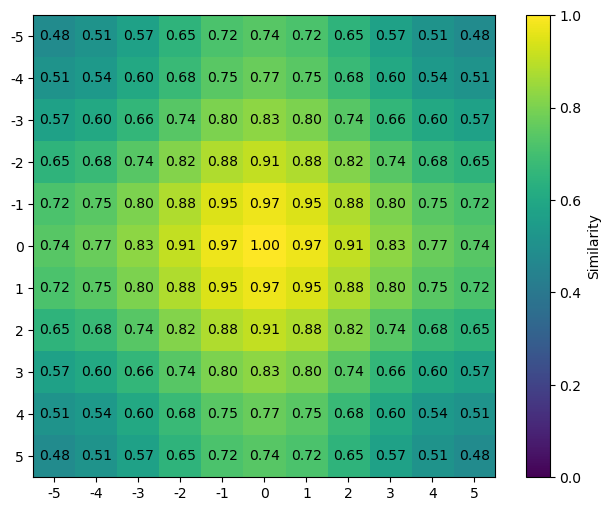

In [21]:
M_2d_rope = np.array([np.arange(SEQ_LEN),]*(DIMENSION//2))
M_2d_rope[0::2] = M_2d_rope[0::2] % LINE_LENGTH
M_2d_rope[1::2] = M_2d_rope[1::2] // LINE_LENGTH

theta_2d_rope = np.array([[1/10000**(2*(i//2)/DIMENSION)] for i in range(DIMENSION//2)])
X_2d_rope = rope(X, channel_thetas=theta_2d_rope, M=M_2d_rope)
similarity_matrix_2d = cosine_similarity(X_2d_rope, X_2d_rope)
plot_similarity_matrix(similarity_matrix_2d)
plot_spatial_similarity(3, 11, 11, similarity_matrix_2d, LINE_LENGTH)

## Standing Wave RoPE

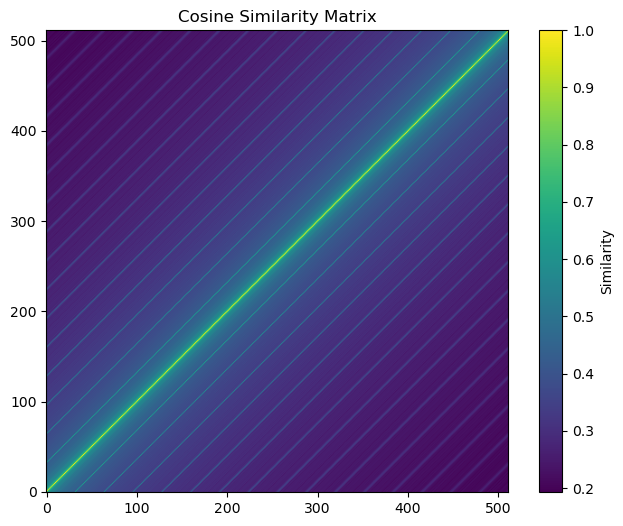

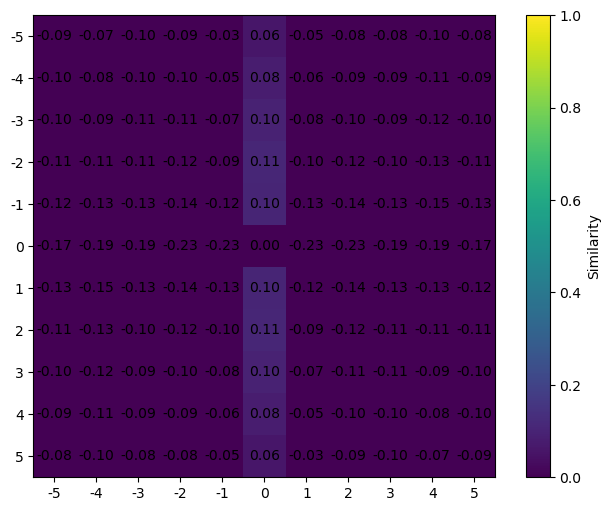

In [72]:
M_sw_rope = M_rope.copy()

MAX_HARMONICS = 16
standing_wave = np.arange(DIMENSION//2).reshape(-1,1) // (DIMENSION//2//MAX_HARMONICS)
standing_wave = 2 * np.pi * standing_wave / (LINE_LENGTH + np.random.randn(DIMENSION//2,1)/8)
theta_sw_rope = theta_rope.copy()

RATE = 4
theta_sw_rope[RATE-1::RATE] = standing_wave[RATE-1::RATE]


X_sw_rope = rope(X, channel_thetas=theta_sw_rope, M=M_sw_rope)
similarity_matrix_sw = cosine_similarity(X_sw_rope, X_sw_rope)
plot_similarity_matrix(similarity_matrix_sw)
plot_spatial_similarity(3, 11, 11, similarity_matrix_sw, LINE_LENGTH)


## Interleaved RoPE

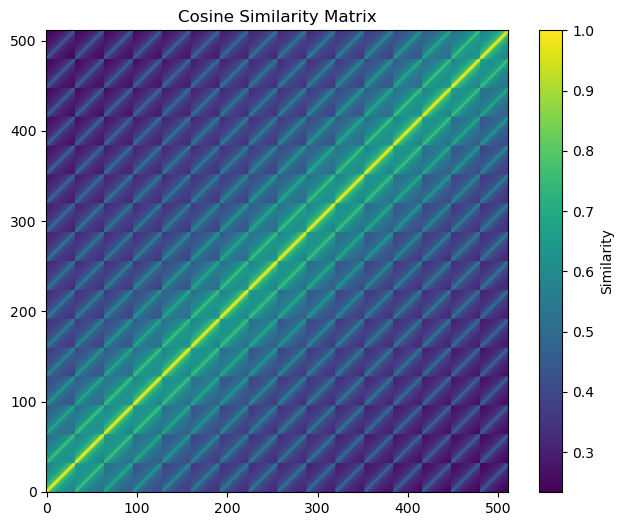

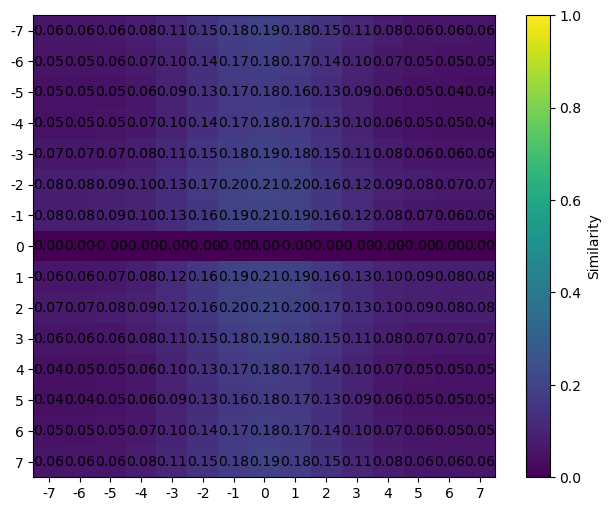

In [76]:
RATE = 4
M_inter_rope = M_rope.copy()
M_inter_rope[RATE-2::RATE] = M_2d_rope[RATE-2::RATE]
M_inter_rope[RATE-1::RATE] = M_2d_rope[RATE-1::RATE]

theta_inter_rope = theta_rope.copy()
theta_inter_rope[RATE-2::RATE] = theta_2d_rope[RATE-2::RATE]
theta_inter_rope[RATE-1::RATE] = theta_2d_rope[RATE-1::RATE]

X_inter_rope = rope(X, channel_thetas=theta_inter_rope, M=M_inter_rope)
similarity_matrix_inter = cosine_similarity(X_inter_rope, X_inter_rope)
plot_similarity_matrix(similarity_matrix_inter)
plot_spatial_similarity(3, 15, 15, similarity_matrix_inter - similarity_matrix_rope, LINE_LENGTH)
